# Foundation model Water Level Forecasting

This repository contains a Python implementation for water level forecasting using the TimesFM model. The model performs a rolling forecast to predict water levels at a given gauge location for three days ahead. The code is organized into multiple sections for loading data, training the model, forecasting, and evaluating the results.

---



## Sections

1. **Install Required Libraries and Import Modules**  
   Installs the necessary libraries and imports the required Python modules for data manipulation, machine learning, and visualization.
2. **Data Loading and Preprocessing**  
   Loads the water discharge data from a CSV file, preprocesses the data by handling missing values, and prepares the dataset for time series forecasting.

3. **Time Series Data Splitting and Visualization**  
   Splits the dataset into training, validation, and test sets. Visualizes the water levels over time and highlights the training, validation, and test periods.

4. **Initialize TimesFM Model**  
   Initializes the TimesFM model with pretrained weights and sets the necessary hyperparameters for forecasting.

5. **Rolling Forecast Using TimesFM**  
   Performs a rolling forecast on the water level data using the TimesFM model, predicting three days ahead for each rolling window.

6. **Processing Forecast Results**  
   Processes the forecast results to shift and align the predicted values with the actual observed values.

7. **Visualization of Forecast vs Observed Data**  
   Visualizes the forecasted values (for Day 1, Day 2, and Day 3) against the observed water levels to assess the model’s performance.

8. **Model Evaluation - Nash-Sutcliffe and Kling-Gupta Efficiency**  
   Evaluates the model performance using two common evaluation metrics: Nash-Sutcliffe Efficiency (NSE) and Kling-Gupta Efficiency (KGE).

---



## Requirements

To run this code, you will need the following libraries:

- `timesfm`
- `tensorflow`
- `pandas`
- `numpy`
- `matplotlib`
- `google.colab`

You can install the required libraries by running the following commands:


`!pip install timesfm'`

---



##Usage
1. Clone the repository:
`git clone https://github.com/your-username/water-level-forecasting.git`


2. Upload your dataset to Google Drive and update the path to the dataset in the script:

`data_file = '/content/drive/MyDrive/germany_gauges/CAMELS_DE_discharge_sim_DE214640.csv'`


3. Run the script on Google Colab to perform time series forecasting:

*   Load and preprocess the data.
*   Train the TimesFM model on the training data.
*   Perform a rolling forecast on the test data.
*   Visualize and evaluate the results.


#**1. Install Required Libraries and Import Modules**

In [1]:
# Install necessary libraries
!pip install timesfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00


In [2]:
# Import required libraries for data manipulation, modeling, and visualization
import pandas as pd
import matplotlib.pyplot as plt
import timesfm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0].


#**2. Data Loading and Preprocessing**


In [3]:
# Mount Google Drive to access data stored in it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset (CSV file with discharge data)
data_file = '/content/drive/MyDrive/Biomet/historique_demande_electricite_quebec_daily.csv'
df = pd.read_csv(data_file)

In [5]:
# Convert 'date' column to datetime format and sort data
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Drop rows with missing discharge observations and reset index
df = df.dropna(subset=['discharge_spec_obs', 'discharge_spec_sim_lstm']).reset_index(drop=True)

# Add a unique identifier and prepare time series data
df['unique_id'] = 1
df['ds'] = df['date']
df['wl'] = df['discharge_spec_obs']

# Prepare the DataFrame for the time series
time_series_df = df[['unique_id', 'ds', 'wl']]

KeyError: ['discharge_spec_obs', 'discharge_spec_sim_lstm']

# **3. Time Series Data Splitting and Visualization**

In [ ]:
# Determine the indices for splitting the time series data
n = len(time_series_df)  # Total number of data points
train_idx = int(0.8 * n)  # First 80% for training
valid_idx = int(0.9 * n)  # Next 10% for validation

In [ ]:
plt.figure(figsize=(15, 8))

# Plot the water level data
plt.plot(time_series_df['ds'], time_series_df['wl'], label="Water Level", color='b')

# Shade the training, validation, and testing sets
plt.axvspan(time_series_df['ds'].iloc[0], time_series_df['ds'].iloc[train_idx], color='lightblue', alpha=0.4, label="Training Set")
plt.axvspan(time_series_df['ds'].iloc[train_idx], time_series_df['ds'].iloc[valid_idx], color='lightgreen', alpha=0.4, label="Validation Set")
plt.axvspan(time_series_df['ds'].iloc[valid_idx], time_series_df['ds'].iloc[-1], color='lightcoral', alpha=0.4, label="Testing Set")

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Water Level")
plt.title("Measured Water Level Over the Years at Gauge 01BO001")
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#**4. Initialize TimesFM Model**

In [ ]:
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=16,
        horizon_len=3,  # 3-day forecast horizon
        context_len=352,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    ),
)

# **5. Rolling Forecast Using TimesFM**

In [16]:
# Prepare results list to store forecasted values
results = []

# Rolling forecast: predict 3 days at a time, advancing by 1 day in each loop
for i in range(len(test_df) - 2):  # Ensure there's enough data for 3-day forecasts
    # Forecast the next three days
    forecast_df = tfm.forecast_on_df(
        inputs=train_df,
        freq="d",  # daily input data
        value_name="wl",
        num_jobs=-1,
    )

    # Extract h1, h2, h3 from the forecast
    h1, h2, h3 = forecast_df['timesfm'].iloc[0], forecast_df['timesfm'].iloc[1], forecast_df['timesfm'].iloc[2]

    # Append to results with corresponding observation for the first day of each period
    results.append({
        'date': test_df['ds'].iloc[i],
        'h1': h1,
        'h2': h2,
        'h3': h3,
        'obs': test_df['wl'].iloc[i]  # Observed value on the first day of the forecast period
    })

    # Update the training data with the actual observation of the current day
    train_df = pd.concat([train_df, test_df.iloc[[i]]], ignore_index=True)


NameError: name 'test_df' is not defined

# **6. Processing Forecast Results**

In [ ]:
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Shift the forecasted values (h1, h2, h3) by one day
results_df[['h1', 'h2', 'h3']] = results_df[['h1', 'h2', 'h3']].shift(-1)
results_df = results_df[:-1]

# Display the resulting DataFrame
print(results_df.head())

# Section 9: Plot the Forecasted Results vs Observed Data
plt.figure(figsize=(15, 8))
plt.plot(results_df['date'], results_df['obs'], label="Observed", color='b')
plt.plot(results_df['date'], results_df['h1'], label="Forecast (Day 1)", color='r')
plt.plot(results_df['date'], results_df['h2'], label="Forecast (Day 2)", color='orange')
plt.plot(results_df['date'], results_df['h3'], label="Forecast (Day 3)", color='green')
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.title("Three-Day-Ahead TimesFM Rolling Forecast (One Day at a Time) vs Observed Water Levels")
plt.legend()
plt.tight_layout()
plt.show()

# **7.Visualization of Forecast vs Observed Data**

        date        h1        h2        h3    obs
0 2020-01-01  2.392130  2.320273  2.305820  2.400
1 2020-01-02  2.413443  2.349820  2.332265  2.459
2 2020-01-03  2.598055  2.504506  2.456340  2.536
3 2020-01-04  2.519844  2.435266  2.391467  2.502
4 2020-01-05  2.434211  2.382959  2.342947  2.448


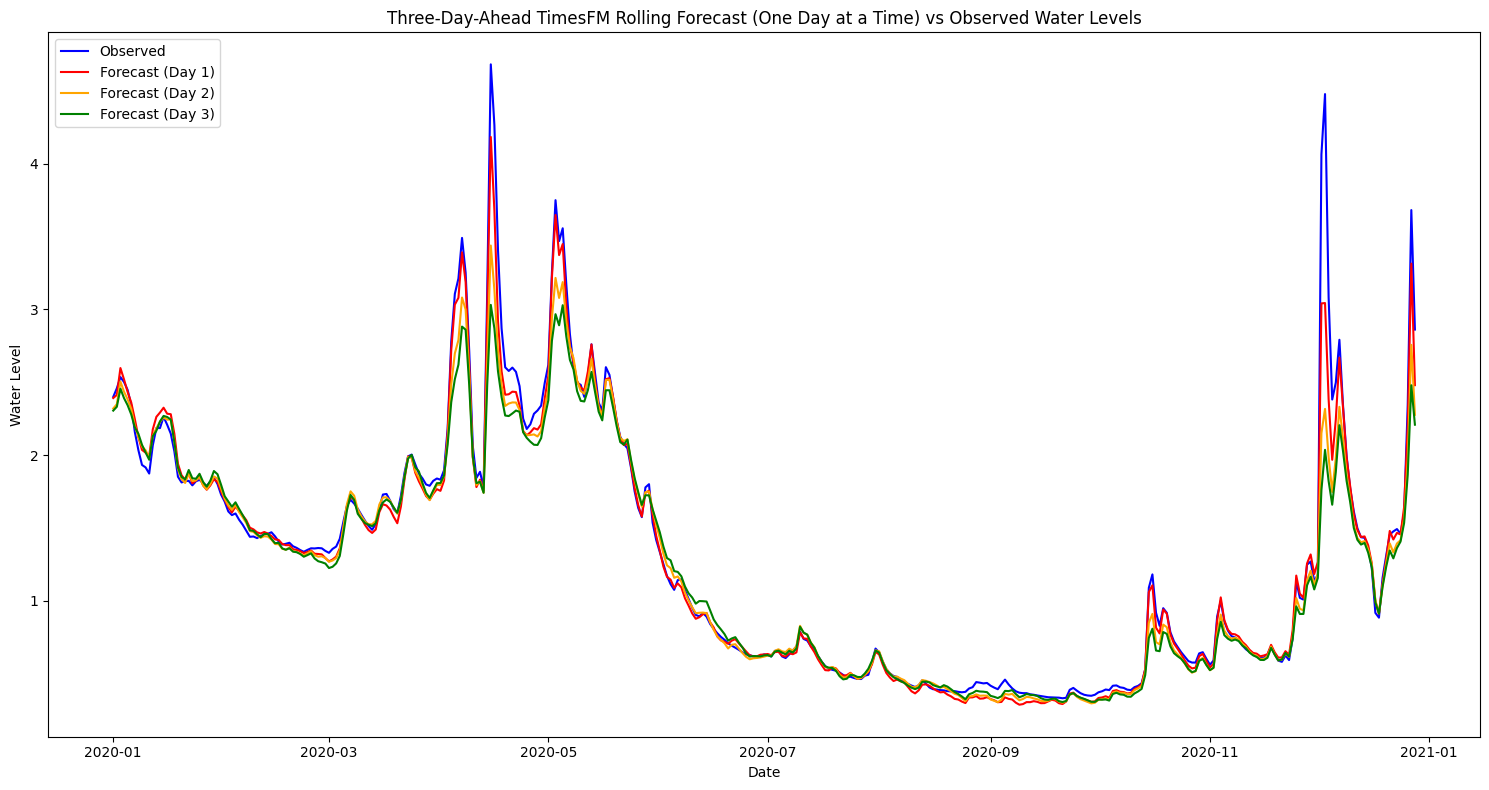

In [ ]:
# Function to plot forecasted values against observed values
def plot_forecast_vs_observed(results_df):
    """
    Visualizes the observed water levels and the corresponding forecasted values for the 1st, 2nd, and 3rd days.
    """
    plt.figure(figsize=(15, 8))
    plt.plot(results_df['date'], results_df['obs'], label="Observed", color='b')
    plt.plot(results_df['date'], results_df['h1'], label="Forecast (Day 1)", color='r')
    plt.plot(results_df['date'], results_df['h2'], label="Forecast (Day 2)", color='orange')
    plt.plot(results_df['date'], results_df['h3'], label="Forecast (Day 3)", color='green')
    plt.xlabel("Date")
    plt.ylabel("Water Level")
    plt.title("Three-Day-Ahead TimesFM Rolling Forecast vs Observed Water Levels")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the plot function to display forecast vs observed comparison
plot_forecast_vs_observed(results_df)

#**8. Model Evaluation - Nash-Sutcliffe and Kling-Gupta Efficiency**

In [ ]:
# Function to calculate Nash-Sutcliffe Efficiency (NSE)
def nse(observed, forecasted):
    numerator = np.sum((observed - forecasted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Function to calculate Kling-Gupta Efficiency (KGE)
def kge(observed, forecasted):
    # Calculate correlation coefficient
    r = np.corrcoef(observed, forecasted)[0, 1]

    # Calculate variability ratio (alpha)
    alpha = np.std(forecasted) / np.std(observed)

    # Calculate bias ratio (beta)
    beta = np.mean(forecasted) / np.mean(observed)

    # Calculate KGE
    kge_value = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge_value

# Section 11: Calculate and Print NSE and KGE for Forecasts
observed = results_df['obs'].values

# Calculate NSE and KGE for the 1st day forecast (h1)
forecasted_h1 = results_df['h1'].values
nse_h1 = nse(observed, forecasted_h1)
kge_h1 = kge(observed, forecasted_h1)

# Print NSE and KGE values
print(f"Nash-Sutcliffe Efficiency (NSE) for 1st day forecast: {nse_h1}")
print(f"Kling-Gupta Efficiency (KGE) for 1st day forecast: {kge_h1}")

# Repeat for the 2nd day (h2) and 3rd day (h3) forecasts
forecasted_h2 = results_df['h2'].values
forecasted_h3 = results_df['h3'].values

nse_h2 = nse(observed, forecasted_h2)
kge_h2 = kge(observed, forecasted_h2)

nse_h3 = nse(observed, forecasted_h3)
kge_h3 = kge(observed, forecasted_h3)

# Print results for each forecast horizon
print(f"Nash-Sutcliffe Efficiency (NSE) for 2nd day forecast: {nse_h2}")
print(f"Kling-Gupta Efficiency (KGE) for 2nd day forecast: {kge_h2}")
print(f"Nash-Sutcliffe Efficiency (NSE) for 3rd day forecast: {nse_h3}")
print(f"Kling-Gupta Efficiency (KGE) for 3rd day forecast: {kge_h3}")

Nash-Sutcliffe Efficiency (NSE) for 1st day forecast: 0.9782593715776753
Kling-Gupta Efficiency (KGE) for 1st day forecast: 0.9401559931248584
Nash-Sutcliffe Efficiency (NSE) for 2nd day forecast: 0.934100715771152
Kling-Gupta Efficiency (KGE) for 2nd day forecast: 0.8716527244576276
Nash-Sutcliffe Efficiency (NSE) for 3rd day forecast: 0.900456409051174
Kling-Gupta Efficiency (KGE) for 3rd day forecast: 0.8330788748073078


##License
ADD License if existent

##Acknowledgments
*  Funding ...
TimesFM: A state-of-the-art model for time series forecasting.
*  Google Colab: For providing a free platform for running and sharing the code.
*  Original dataset: The dataset used in this project is based on the CAMELS dataset.